In [1]:
# Imports
from src import *
import scipy.sparse.linalg as spsl
import pickle
import matplotlib.pyplot as plt
import matplotlib

In [2]:
# Algorithm parameters
num_qubits = 10
max_energy_level = 4
kd_ratio = 2.5
# epsilon_values = 1/(10**np.arange(2,9,.5))
# noise_thresholds = [10 * epsilon for epsilon in epsilon_values]
noise_thresholds = 1/(10**np.arange(1,8,.5))
epsilon_values = np.array([delta/10 for delta in noise_thresholds])
K = 299
delta_t = 0.3279896435915973
# num_modmd_observables = 6
num_trials = 5

In [3]:
# Load Hamiltonian, get true eigenergies
with open('Data/Hamiltonians/LiH_equilibrium_hamiltonian.pkl', 'rb') as f:
    sparse_lih_hamiltonian = pickle.load(f)
eigenvalues = np.sort(spsl.eigsh(sparse_lih_hamiltonian,k=20,which = 'SA')[0])
true_eigenenergies = eigenvalues[[0,3,6,11,17]]

In [4]:
# Construct reference state
reference_state = bitstring_superposition_state(num_qubits, ['0000100001', '0000000011', '0001000001','0010100000'])

# Get evolved reference states
d = int((K)/kd_ratio)
time_evolution_operator = -1j*sparse_lih_hamiltonian*delta_t
evolved_reference_states = spsl.expm_multiply(time_evolution_operator,reference_state,start=0,stop=d+K+1,num = d+K+2)

In [5]:
# Get MODMD observables
with open('Data/Hamiltonians/LiH_pauli_representation.pkl', 'rb') as f:
    lih_pauli_coefficients, lih_pauli_strings = pickle.load(f)

sorted_pauli_observables = np.array(lih_pauli_strings)[np.argsort(np.abs(lih_pauli_coefficients))[::-1]]
modmd_observables = [SparsePauliOp(p).to_matrix(sparse=True) for p in sorted_pauli_observables[75:81]]

In [6]:
# ODMD Results
odmd_results = {epsilon:[] for epsilon in epsilon_values}
odmd_observables = [SparsePauliOp('I' * num_qubits).to_matrix(sparse=True)]

X_elements = generate_X_elements(odmd_observables,d,K,reference_state,evolved_reference_states)

for i,epsilon in enumerate(epsilon_values):
    
    for trial in range(num_trials):

        gaussian_noise = np.random.normal(0,epsilon,size=X_elements.shape) + 1j * np.random.normal(0,epsilon,size=X_elements.shape)
        noisy_X_elements = X_elements + gaussian_noise

        odmd_results[epsilon].append(one_shot_modmd(len(odmd_observables),noise_thresholds[i],noisy_X_elements,delta_t,K,kd_ratio,max_energy_level))

In [7]:
# MODMD Results
modmd_results = {epsilon:[] for epsilon in epsilon_values}
X_elements = generate_X_elements(modmd_observables,d,K,reference_state,evolved_reference_states)

for i,epsilon in enumerate(epsilon_values):
    
    for trial in range(num_trials):

        gaussian_noise = np.random.normal(0,epsilon,size=X_elements.shape) + 1j * np.random.normal(0,epsilon,size=X_elements.shape)
        noisy_X_elements = X_elements + gaussian_noise

        modmd_results[epsilon].append(one_shot_modmd(len(modmd_observables),noise_thresholds[i],noisy_X_elements,delta_t,K,kd_ratio,max_energy_level))

In [8]:
# Compute errors
absolute_odmd_errors = {epsilon: np.array([np.abs(odmd_results[epsilon][i] - true_eigenenergies) 
for i in range(num_trials)]) for epsilon in epsilon_values}
absolute_modmd_errors = {epsilon: np.array([np.abs(modmd_results[epsilon][i] - true_eigenenergies) 
for i in range(num_trials)]) for epsilon in epsilon_values}

odmd_errors_average = np.array([np.average(absolute_odmd_errors[epsilon],0) for epsilon in epsilon_values])
modmd_errors_average = np.array([np.average(absolute_modmd_errors[epsilon],0) for epsilon in epsilon_values])

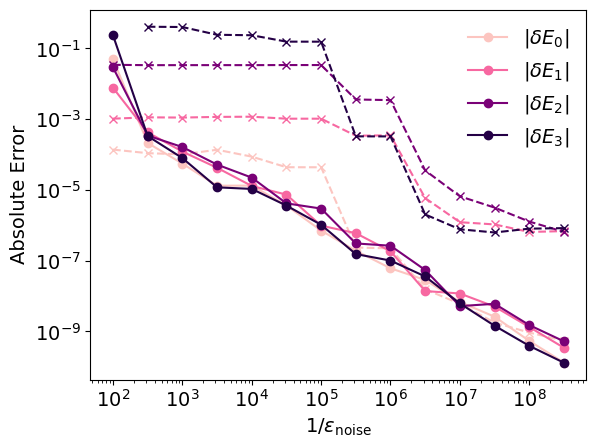

In [11]:
# Plotting
energy_levels = [0,1,2,3]
colors = ['#fcc5c0','#f768a1','#7a0177', '#240046']
labels = [r'$|\delta E_0|$',r'$|\delta E_1|$',r'$|\delta E_2|$',r'$|\delta E_3|$']

for i, energy_level in enumerate(energy_levels):
    plt.loglog(1/epsilon_values,odmd_errors_average[:,energy_level], '--x', color = colors[i])
    plt.loglog(1/epsilon_values,modmd_errors_average[:,energy_level], '-o', color = colors[i], label = labels[i])

matplotlib.rcParams.update({'font.size': 14})
plt.xlabel(r'1/$\epsilon_\text{noise}$')
plt.ylabel('Absolute Error')
plt.legend(framealpha = 0, fontsize = 14)